# Predictive Maintenance

## Dataset 1 - Regression (RUL) using Autoencoder + Kalman + LSTM

Here, we fit an autoencoder on the train set which learns to regenerate the train set. By using the activations of some intermediate layer of the autoencoder, we get an efficient representation of the original noisy train data. This representation of the original data can be used to train the LSTM model for predicting RUL.

In [0]:
import keras
!pip install pykalman

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

## Preprocess Train and Test Data using Kalman Filtering

In [0]:
# read training data 
train_df = pd.read_csv('train_01.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [0]:
from pykalman import KalmanFilter

In [0]:

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [0]:
train_df.columns
cols = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [0]:
train_df.columns[2]

'setting1'

In [0]:
for cols in train_df.columns:
    if cols == 'id':
        continue;
    if cols == 'cycle':
        continue;
    else:
        print(cols)
        kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = train_df[cols].values[0],
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
        state_means,_ = kf.filter(train_df[cols].values)
        train_df[cols] = state_means.flatten()

setting1
setting2
setting3
s1
s2
s3
s4
s5
s6
s7
s8
s9
s10
s11
s12
s13
s14
s15
s16
s17
s18
s19
s20
s21


In [0]:
# read test data
test_df = pd.read_csv('test_01.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [0]:
for cols in test_df.columns:
    if cols == 'id':
        continue;
    if cols == 'cycle':
        continue;
    else:
        print(cols)
        kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = test_df[cols].values[0],
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
        state_means,_ = kf.filter(test_df[cols].values)
        test_df[cols] = state_means.flatten()

setting1
setting2
setting3
s1
s2
s3
s4
s5
s6
s7
s8
s9
s10
s11
s12
s13
s14
s15
s16
s17
s18
s19
s20
s21


In [0]:
# read ground truth data
truth_df = pd.read_csv('truth_01.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [0]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.000700,-0.000400,100.0,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.060000,9046.190000,1.3,47.470000,521.660000,2388.020000,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.419000
1,1,2,0.000178,-0.000366,100.0,518.67,641.931457,1590.416026,1401.457881,14.62,21.61,554.153974,2388.053245,9045.473974,1.3,47.476755,521.869404,2388.036887,8136.211854,8.423654,0.03,392.000000,2388.0,100.0,39.039735,23.420554
2,1,3,-0.000977,-0.000194,100.0,518.67,642.039450,1589.790059,1402.165407,14.62,21.61,554.181331,2388.060148,9047.400370,1.3,47.423408,522.011470,2388.035110,8135.442471,8.422144,0.03,391.483957,2388.0,100.0,39.016581,23.400853
3,1,4,-0.000623,-0.000153,100.0,518.67,642.105091,1588.310457,1402.102967,14.62,21.61,554.238119,2388.070686,9047.839942,1.3,47.361390,522.190824,2388.044599,8135.101643,8.410742,0.03,391.593033,2388.0,100.0,38.987712,23.395156
4,1,5,-0.000854,-0.000162,100.0,518.67,642.153105,1587.320764,1402.849168,14.62,21.61,554.194961,2388.068749,9049.164870,1.3,47.346638,522.190674,2388.043765,8134.865724,8.414123,0.03,391.848042,2388.0,100.0,38.971815,23.396831


## Generate True Labels (RUL) for Train Data

In [0]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.000700,-0.000400,100.0,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.060000,9046.190000,1.3,47.470000,521.660000,2388.020000,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.419000,191
1,1,2,0.000178,-0.000366,100.0,518.67,641.931457,1590.416026,1401.457881,14.62,21.61,554.153974,2388.053245,9045.473974,1.3,47.476755,521.869404,2388.036887,8136.211854,8.423654,0.03,392.000000,2388.0,100.0,39.039735,23.420554,190
2,1,3,-0.000977,-0.000194,100.0,518.67,642.039450,1589.790059,1402.165407,14.62,21.61,554.181331,2388.060148,9047.400370,1.3,47.423408,522.011470,2388.035110,8135.442471,8.422144,0.03,391.483957,2388.0,100.0,39.016581,23.400853,189
3,1,4,-0.000623,-0.000153,100.0,518.67,642.105091,1588.310457,1402.102967,14.62,21.61,554.238119,2388.070686,9047.839942,1.3,47.361390,522.190824,2388.044599,8135.101643,8.410742,0.03,391.593033,2388.0,100.0,38.987712,23.395156,188
4,1,5,-0.000854,-0.000162,100.0,518.67,642.153105,1587.320764,1402.849168,14.62,21.61,554.194961,2388.068749,9049.164870,1.3,47.346638,522.190674,2388.043765,8134.865724,8.414123,0.03,391.848042,2388.0,100.0,38.971815,23.396831,187


In [0]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.000700,-0.000400,100.0,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.060000,9046.190000,1.3,47.470000,521.660000,2388.020000,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.419000,191,0,0
1,1,2,0.000178,-0.000366,100.0,518.67,641.931457,1590.416026,1401.457881,14.62,21.61,554.153974,2388.053245,9045.473974,1.3,47.476755,521.869404,2388.036887,8136.211854,8.423654,0.03,392.000000,2388.0,100.0,39.039735,23.420554,190,0,0
2,1,3,-0.000977,-0.000194,100.0,518.67,642.039450,1589.790059,1402.165407,14.62,21.61,554.181331,2388.060148,9047.400370,1.3,47.423408,522.011470,2388.035110,8135.442471,8.422144,0.03,391.483957,2388.0,100.0,39.016581,23.400853,189,0,0
3,1,4,-0.000623,-0.000153,100.0,518.67,642.105091,1588.310457,1402.102967,14.62,21.61,554.238119,2388.070686,9047.839942,1.3,47.361390,522.190824,2388.044599,8135.101643,8.410742,0.03,391.593033,2388.0,100.0,38.987712,23.395156,188,0,0
4,1,5,-0.000854,-0.000162,100.0,518.67,642.153105,1587.320764,1402.849168,14.62,21.61,554.194961,2388.068749,9049.164870,1.3,47.346638,522.190674,2388.043765,8134.865724,8.414123,0.03,391.848042,2388.0,100.0,38.971815,23.396831,187,0,0


## Normalize Train and Test Data

In [0]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.368542,0.000000,0.0,0.0,0.000000,0.349894,0.185846,0.0,1.0,0.878722,0.242639,0.091191,0.0,0.356551,0.685441,0.131931,0.207883,0.265399,0.0,0.184954,0.0,0.0,0.938255,0.901462,191,0,0,0.00000
1,1,2,0.606362,0.045503,0.0,0.0,0.058599,0.381941,0.211315,0.0,1.0,0.818707,0.220732,0.086909,0.0,0.363140,0.757866,0.184063,0.191990,0.295538,0.0,0.184954,0.0,0.0,0.907757,0.905421,190,0,0,0.00277
2,1,3,0.293440,0.277092,0.0,0.0,0.115377,0.353925,0.232320,0.0,1.0,0.826676,0.243121,0.098430,0.0,0.311104,0.807002,0.178577,0.186913,0.284579,0.0,0.092264,0.0,0.0,0.872911,0.855227,189,0,0,0.00554
3,1,4,0.389455,0.332429,0.0,0.0,0.149888,0.287703,0.230467,0.0,1.0,0.843218,0.277295,0.101059,0.0,0.250610,0.869034,0.207868,0.184663,0.201857,0.0,0.111856,0.0,0.0,0.829464,0.840712,188,0,0,0.00831
4,1,5,0.326762,0.321014,0.0,0.0,0.175131,0.243408,0.252620,0.0,1.0,0.830646,0.271014,0.108983,0.0,0.236221,0.868982,0.205295,0.183106,0.226392,0.0,0.157660,0.0,0.0,0.805538,0.844981,187,0,0,0.01108


In [0]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,1.181006,0.943062,0.0,0.0,0.630905,0.152518,0.114891,0.0,1.0,0.744724,0.177775,0.114995,0.0,0.093186,0.706193,0.162801,0.121627,0.161653,0.0,0.184954,0.0,0.0,0.637261,0.785538,0.00000
1,1,2,0.723659,0.670047,0.0,0.0,0.398285,0.200286,0.086915,0.0,1.0,0.838191,0.144913,0.123580,0.0,0.192020,0.757592,0.194081,0.152988,0.100639,0.0,0.245620,0.0,0.0,0.718589,0.801113,0.00277
2,1,3,0.701909,0.670968,0.0,0.0,0.382339,0.207015,0.118110,0.0,1.0,0.829858,0.161760,0.131843,0.0,0.242023,0.766640,0.186010,0.152644,0.189200,0.0,0.276312,0.0,0.0,0.783034,0.825428,0.00554
3,1,4,0.911938,0.643051,0.0,0.0,0.370424,0.184428,0.168949,0.0,1.0,0.822331,0.158290,0.122113,0.0,0.227058,0.729007,0.194155,0.156341,0.162675,0.0,0.219036,0.0,0.0,0.796756,0.817104,0.00831
4,1,5,0.916529,0.624173,0.0,0.0,0.369036,0.194057,0.179114,0.0,1.0,0.821992,0.144187,0.114730,0.0,0.222241,0.751828,0.188472,0.154822,0.159729,0.0,0.147749,0.0,0.0,0.803308,0.829623,0.01108


## Generate True Labels (RUL) for Test Data

In [0]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [0]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,1.181006,0.943062,0.0,0.0,0.630905,0.152518,0.114891,0.0,1.0,0.744724,0.177775,0.114995,0.0,0.093186,0.706193,0.162801,0.121627,0.161653,0.0,0.184954,0.0,0.0,0.637261,0.785538,0.00000,142
1,1,2,0.723659,0.670047,0.0,0.0,0.398285,0.200286,0.086915,0.0,1.0,0.838191,0.144913,0.123580,0.0,0.192020,0.757592,0.194081,0.152988,0.100639,0.0,0.245620,0.0,0.0,0.718589,0.801113,0.00277,141
2,1,3,0.701909,0.670968,0.0,0.0,0.382339,0.207015,0.118110,0.0,1.0,0.829858,0.161760,0.131843,0.0,0.242023,0.766640,0.186010,0.152644,0.189200,0.0,0.276312,0.0,0.0,0.783034,0.825428,0.00554,140
3,1,4,0.911938,0.643051,0.0,0.0,0.370424,0.184428,0.168949,0.0,1.0,0.822331,0.158290,0.122113,0.0,0.227058,0.729007,0.194155,0.156341,0.162675,0.0,0.219036,0.0,0.0,0.796756,0.817104,0.00831,139
4,1,5,0.916529,0.624173,0.0,0.0,0.369036,0.194057,0.179114,0.0,1.0,0.821992,0.144187,0.114730,0.0,0.222241,0.751828,0.188472,0.154822,0.159729,0.0,0.147749,0.0,0.0,0.803308,0.829623,0.01108,138


In [0]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,1.181006,0.943062,0.0,0.0,0.630905,0.152518,0.114891,0.0,1.0,0.744724,0.177775,0.114995,0.0,0.093186,0.706193,0.162801,0.121627,0.161653,0.0,0.184954,0.0,0.0,0.637261,0.785538,0.00000,142,0,0
1,1,2,0.723659,0.670047,0.0,0.0,0.398285,0.200286,0.086915,0.0,1.0,0.838191,0.144913,0.123580,0.0,0.192020,0.757592,0.194081,0.152988,0.100639,0.0,0.245620,0.0,0.0,0.718589,0.801113,0.00277,141,0,0
2,1,3,0.701909,0.670968,0.0,0.0,0.382339,0.207015,0.118110,0.0,1.0,0.829858,0.161760,0.131843,0.0,0.242023,0.766640,0.186010,0.152644,0.189200,0.0,0.276312,0.0,0.0,0.783034,0.825428,0.00554,140,0,0
3,1,4,0.911938,0.643051,0.0,0.0,0.370424,0.184428,0.168949,0.0,1.0,0.822331,0.158290,0.122113,0.0,0.227058,0.729007,0.194155,0.156341,0.162675,0.0,0.219036,0.0,0.0,0.796756,0.817104,0.00831,139,0,0
4,1,5,0.916529,0.624173,0.0,0.0,0.369036,0.194057,0.179114,0.0,1.0,0.821992,0.144187,0.114730,0.0,0.222241,0.751828,0.188472,0.154822,0.159729,0.0,0.147749,0.0,0.0,0.803308,0.829623,0.01108,138,0,0


In [0]:
train_df.drop(['label1','label2'],axis=1,inplace=True)
test_df.drop(['label1','label2'],axis=1,inplace=True)

In [0]:
cols = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 
        's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'cycle_norm']
len(cols)

25

# Autoencoder

In [0]:
from keras.layers import Input, Dense
from keras import Model
from keras import regularizers, optimizers, activations

In [0]:
input_dim = len(cols)
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [0]:
data = pd.concat([train_df[cols], test_df[cols]])
data.shape

(33727, 25)

## Train the Autoencoder

In [0]:
from keras.callbacks import ModelCheckpoint

nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'mse'])

checkpointer = ModelCheckpoint(filepath="autoenc_rul_model.h5", verbose=0, save_best_only=True)

history = autoencoder.fit(data, data, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                    validation_split=0.15, verbose=1, callbacks=[checkpointer]).history

Train on 28667 samples, validate on 5060 samples
Epoch 1/100
28667/28667 [==============================] - 4s 125us/step - loss: 0.0486 - acc: 0.8335 - mean_squared_error: 0.0430 - val_loss: 0.0352 - val_acc: 0.8656 - val_mean_squared_error: 0.0335
Epoch 2/100
28667/28667 [==============================] - 3s 107us/step - loss: 0.0389 - acc: 0.8545 - mean_squared_error: 0.0374 - val_loss: 0.0342 - val_acc: 0.8791 - val_mean_squared_error: 0.0331
Epoch 3/100
28667/28667 [==============================] - 3s 107us/step - loss: 0.0379 - acc: 0.8654 - mean_squared_error: 0.0368 - val_loss: 0.0336 - val_acc: 0.8893 - val_mean_squared_error: 0.0326
Epoch 4/100
28667/28667 [==============================] - 3s 107us/step - loss: 0.0371 - acc: 0.8724 - mean_squared_error: 0.0361 - val_loss: 0.0329 - val_acc: 0.8927 - val_mean_squared_error: 0.0320
Epoch 5/100
28667/28667 [==============================] - 3s 111us/step - loss: 0.0364 - acc: 0.8872 - mean_squared_error: 0.0356 - val_loss: 0.03

In [0]:
from keras.models import Model, load_model
autoencoder = load_model('autoenc_rul_model.h5')

In [0]:
predictions = autoencoder.predict(data)
feat = pd.DataFrame(predictions)
feat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.367734,0.111243,0.0,0.0,0.231750,0.161641,0.177416,0.0,0.988763,0.823335,0.192579,0.120866,0.0,0.0,0.838129,0.208803,0.0,0.183575,0.0,0.172723,0.0,0.0,0.815427,0.0,0.015382
1,0.597986,0.094591,0.0,0.0,0.253239,0.180008,0.201949,0.0,0.988076,0.800809,0.207755,0.131713,0.0,0.0,0.816612,0.223240,0.0,0.206183,0.0,0.194371,0.0,0.0,0.794389,0.0,0.007314
2,0.283073,0.283757,0.0,0.0,0.245948,0.176026,0.193508,0.0,0.987813,0.808863,0.207236,0.121385,0.0,0.0,0.822638,0.222524,0.0,0.199970,0.0,0.184071,0.0,0.0,0.799482,0.0,0.001823
3,0.380589,0.339491,0.0,0.0,0.235709,0.160580,0.182724,0.0,0.989290,0.815900,0.212145,0.099778,0.0,0.0,0.829400,0.227189,0.0,0.187921,0.0,0.168029,0.0,0.0,0.810915,0.0,0.003340
4,0.318169,0.327582,0.0,0.0,0.247332,0.175219,0.195529,0.0,0.990162,0.805729,0.214409,0.113440,0.0,0.0,0.819215,0.229381,0.0,0.201294,0.0,0.182914,0.0,0.0,0.798042,0.0,0.006215


## Get the Activations at the Output of Encoder

In [0]:
input_dim = len(cols)
encoding_dim = 14

input_l = Input(shape=(input_dim, ))

enc = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_l)
enc = Dense(int(encoding_dim / 2), activation="relu")(enc)

encod = Model(inputs=input_l, outputs=enc)

In [0]:
encod.set_weights(autoencoder.layers[0].get_weights())

encod.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'mse'])

In [0]:
encod.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 14)                364       
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 105       
Total params: 469
Trainable params: 469
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_act = encod.predict(train_df[cols], verbose=1)
test_act = encod.predict(test_df[cols], verbose=1)

13096/13096 [==============================] - 0s 22us/step


In [0]:
train_act_df = pd.DataFrame(train_act)
test_act_df = pd.DataFrame(test_act)
train_act_df.head()

,0,1,2,3,4,5,6
0,0.0,0.0,0.577386,0.0,0.137588,0.695363,0.993560
1,0.0,0.0,0.556812,0.0,0.060657,0.652261,1.010713
2,0.0,0.0,0.562286,0.0,0.197591,0.712470,0.965784
3,0.0,0.0,0.570767,0.0,0.199277,0.744735,1.005440
4,0.0,0.0,0.561180,0.0,0.218605,0.738037,1.049752


In [0]:
train_act_df['RUL'] = train_df['RUL']
test_act_df['RUL'] = test_df['RUL']
train_act_df['id'] = train_df['id']
test_act_df['id'] = test_df['id']

In [0]:
train.columns = cols
test.columns = cols

NameError: ignored

In [0]:
train['RUL'] = train_df['RUL']
test['RUL'] = test_df['RUL']
train['id'] = train_df['id']
test['id'] = test_df['id']

NameError: ignored

## Train and Test Sequences

In [0]:
# pick a large window size of 50 cycles
sequence_length = 50

In [0]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [0]:
# pick the feature columns 
sensor_cols = [i for i in range(0,20)]

In [0]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [0]:
sensor_cols = [0, 1, 2, 3, 4, 5, 6]

In [0]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_act_df[train_act_df['id']==id], sequence_length, sensor_cols)) 
           for id in train_act_df['id'].unique())

In [0]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 7)

In [0]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [0]:
# generate labels
label_gen = [gen_labels(train_act_df[train_act_df['id']==id], sequence_length, ['RUL']) 
             for id in train_act_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## Model

In [0]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.4))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.4))

model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           43200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
__________________________________________________

## Training the Model

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

STAMP = 'predictive_regression_kalhman'
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

predictive_regression_kalhman


In [0]:
from keras.optimizers import RMSprop

model.compile(loss="mse", optimizer=RMSprop(lr=1e-2), metrics=['mse'])

In [0]:
%%time
# fit the network
hist = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,callbacks=[early_stopping, model_checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 12s 815us/step - loss: 6993.6019 - mean_squared_error: 6993.6019 - val_loss: 5121.3855 - val_mean_squared_error: 5121.3855
Epoch 2/10
14849/14849 [==============================] - 11s 713us/step - loss: 4325.9255 - mean_squared_error: 4325.9255 - val_loss: 3452.9651 - val_mean_squared_error: 3452.9651
Epoch 3/10
14849/14849 [==============================] - 11s 731us/step - loss: 3440.9262 - mean_squared_error: 3440.9262 - val_loss: 3168.7608 - val_mean_squared_error: 3168.7608
Epoch 4/10
14849/14849 [==============================] - 11s 717us/step - loss: 3399.5373 - mean_squared_error: 3399.5373 - val_loss: 3169.8808 - val_mean_squared_error: 3169.8808
Epoch 5/10
14849/14849 [==============================] - 11s 711us/step - loss: 3391.5144 - mean_squared_error: 3391.5144 - val_loss:

In [0]:
model.load_weights(bst_model_path)

In [0]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Score: {}'.format(scores[1]))

15631/15631 [==============================] - 4s 279us/step
Score: 1780.9274901338276


In [0]:
p = pd.DataFrame(np.zeros((1, 25)), columns=cols)
test = pd.concat([test, p])

NameError: ignored

In [0]:
seq_array_test_last = [test_act_df[test_act_df['id']==id][sensor_cols].values[-sequence_length:] 
                       for id in test_act_df['id'].unique() if len(test_act_df[test_act_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 7)

In [0]:
y_mask = [len(test_act_df[test_act_df['id']==id]) >= sequence_length for id in test_act_df['id'].unique()]

In [0]:
label_array_test_last = test_act_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [0]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 7)
(93, 1)


## Results on Test Data

In [0]:
# test metrics
import math
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

Test Score: 572.78 MSE (23.93 RMSE)


In [0]:
pred = model.predict(seq_array_test_last)

In [0]:
diff = []
ratio = []
pred = model.predict(seq_array_test_last)
for u in range(len(label_array_test_last)):
    pr = pred[u][0]
    ratio.append((label_array_test_last[u] / pr) - 1)
    diff.append(abs(label_array_test_last[u] - pr))

## Plot of Predicted and True RUL Values

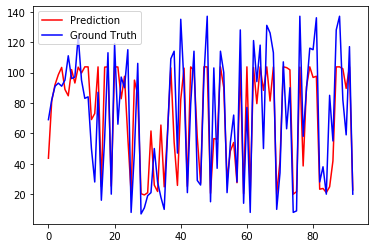

In [0]:
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(label_array_test_last, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

In [0]:
error = pd.DataFrame(( label_array_test_last - pred),columns=['error'])
error.describe()

,error
count,93.000000
mean,1.720670
std,24.000359
min,-47.447212
25%,-12.306889
50%,-1.070902
75%,15.288216
max,60.169930
